# Análisis de las tarifas de prepago Surf y Ultimate de la empresa Megaline por *Carlos Horta* (carlosgim@gmail.com)

---

## Introducción

Megaline es un operador de telecomunicaciones que ofrece dos paquetes de prepago: **Surf** y **Ultimate**.

El objetivo general de este proyecto es apoyar al departamento comercial en determinar qué plan genera más ingresos, con el fin de ajustar el presupuesto de publicidad.

### Objetivos

Este proyecto tiene los siguientes objetivos específicos:

- Describir el comportamiento de los clientes en términos de consumo de minutos, SMS y volumen de datos para cada uno de los dos planes (Surf y Ultimate), utilizando medidas estadísticas.
- Probar la hipótesis de que el ingreso promedio de los usuarios de las tarifas Surf y Ultimate difiere.
- Probar la hipótesis de que el ingreso promedio de los usuarios en el área de New York-Newark-Jersey City es diferente al de los usuarios de otras regiones.

### Conjuntos de datos

Para llevar a cabo este proyecto, se utilizará una muestra de 500 clientes de Megaline a partir de cinco bases de datos con datos del año 2018. Estas bases de datos contienen información sobre usuarios, llamadas, SMS, sesiones web y detalles de las tarifas.


---


### **Descripción de los paquetes Surf y Ultimate**

Megaline ofrece dos paquetes de prepago: Surf y Ultimate. A continuación se describe cada uno de ellos:

#### Surf

- Pago mensual: $20.
- Incluye:
   - 500 minutos al mes.
   - 50 SMS.
   - 15 GB de datos.
- Excedentes:
   - 1 minuto adicional: $0.03.
   - 1 SMS adicional: $0.03.
   - 1 GB de datos adicional: $10.

#### Ultimate

- Pago mensual: $70.
- Incluye:
   - 3000 minutos al mes.
   - 1000 SMS.
   - 30 GB de datos.
- Excedentes:
   - 1 minuto adicional: $0.03.
   - 1 SMS adicional: $0.03.
   - 1 GB de datos adicional: $10.

***Nota sobre las tarifas:*** 

- La duración de cada llamada individual se redondea hacia el minuto superior, sin importar la duración real de la llamada.
- En el caso del tráfico web, las sesiones individuales no se redondean, pero el total de datos utilizado en el mes sí se redondea.


---

### **Exploración de los datos**

A continuación, se cargarán las librerías **pandas**, **matplotlib**, **missingno**, **numpy**, **seaborn** y **numpy** que se utilizarán para este proyecto de Python. 

In [1]:
# Estas son las librerías a utilizar durante el proyecto

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from math import factorial

from scipy import stats as st

from functools import reduce

import math

import statistics

Así mismo, los archivos csv con las bases de datos se cargarán de dos maneras diferentes para asegurar su funcionamiento en varios sistemas operativos y plataformas.

In [2]:
# Carga los datos
try:
    calls = pd.read_csv("megaline_calls.csv")
except:
    calls = pd.read_csv("/datasets/megaline_calls.csv")
    
    
try:
    internet = pd.read_csv("megaline_internet.csv")
except:
    internet = pd.read_csv("/datasets/megaline_internet.csv")

try:
    messages = pd.read_csv("megaline_messages.csv")
except:
    messages = pd.read_csv("/datasets/megaline_messages.csv")
    
try:
    plans = pd.read_csv("megaline_plans.csv")
except:
    plans = pd.read_csv("/datasets/megaline_plans.csv")
    
try:
    users = pd.read_csv("megaline_users.csv")
except:
    users = pd.read_csv("/datasets/megaline_users.csv")

Una vez cargadas las librerías y los datasets es necesario analizar cada una de las 5 tablas de este proyecto.

#### Dataset **'users'**

In [3]:
# El primer dataset a analizar es el de usuarios

users.info()

print(users.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        

La tabla **users** se compone de 8 columnas: el identificador único de cliente, el nombre y el apellido, la edad en años, la fecha de suscripción, la fecha en que se dejó de usar el servicio (según sea el caso), la ciudad de residencia y la tarifa contratada (ya sea Surf o Ultimate).

Decisiones sobre la tabla **users**: 
- La columna 'city' se transformará en dos columnas ('metropolitan_area' y 'state').
- Se eliminarán las columnas 'first_name, 'last_name', 'age', 'city', 'churn_date' y 'state' debido a que no son de interés para el objetivo del proyecto. 

In [4]:
users[['metropolitan_area', 'state']] = users.city.str.split(",",expand=True)
users = users.drop(columns=['first_name', 'last_name','age', 'churn_date', 'state', 'city'])
print(users.head(5))

   user_id    reg_date      plan              metropolitan_area
0     1000  2018-12-24  ultimate  Atlanta-Sandy Springs-Roswell
1     1001  2018-08-13      surf        Seattle-Tacoma-Bellevue
2     1002  2018-10-21      surf   Las Vegas-Henderson-Paradise
3     1003  2018-01-28      surf                          Tulsa
4     1004  2018-05-23      surf        Seattle-Tacoma-Bellevue


#### Dataset **'calls'**

In [5]:
# El segundo dataset a analizar es el de llamadas

calls.info()

print(calls.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


La tabla **calls** se compone de 4 columnas: el identificador único de llamada, la fecha de la llamada, la duración en minutos de la llamada y el identificador único del usuario que realiza la llamada.

Decisiones sobre la tabla **calls**: 
- Se creará la columna duration_rounded para redondear al minuto siguiente la duración de la llamada (por ejemplo, redondear de 8.52 a 9 y de 13.66 a 14).
- Posteriormente, esta nueva columna se convertirá a una de tipo de valores enteros sin decimales.
- Se eliminarán las filas cuya duración de llamada es 0, esto bajo el supuesto que no fueron completadas y no costaron dinero al usuario.



In [6]:
calls['duration_rounded'] = calls['duration'].apply(np.ceil)
calls = calls.astype({'duration_rounded' : 'int'})
calls_cleaned = calls[calls['duration_rounded'] > 0]
calls_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                110901 non-null  object 
 1   user_id           110901 non-null  int64  
 2   call_date         110901 non-null  object 
 3   duration          110901 non-null  float64
 4   duration_rounded  110901 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 4.7+ MB


Hasta este momento, el dataset de llamadas pasó de tener 137,735 registros a 110,901; esto significa una diferencia de 26,834 llamadas con 0 minutos de duración que se eliminaron.

Siguientes decisiones sobre el dataframe de llamadas:
 - Se realizará la agrupación por user_id para identificar el número de llamadas realizadas y minutos utilizados en el mes.
 - El nuevo dataframe se compondrá del id de usuario, la suma de cada llamada realizada (primero se redondeó a su entero superior cada llamada) y el número de llamadas realizadas.

In [7]:
calls_by_user = calls_cleaned.groupby('user_id', as_index=False).agg({'duration_rounded' : 'sum', 'call_date' : 'count'})
calls_by_user.columns = ['user_id', 'duration_rounded', 'calls']
calls_by_user.head(5)

,user_id,duration_rounded,calls
0,1000,124,16
1,1001,1728,202
2,1002,829,94
3,1003,1104,118
4,1004,2772,306


Por último para este dataset de llamadas, se crearán dos columnas adicionales: promedio mensual de minutos consumidos y promedio mensual del número de llamadas realizadas.

In [8]:
calls_by_user['avg_duration_rounded_month'] = calls_by_user['duration_rounded'] / 12
calls_by_user['avg_calls_month'] = calls_by_user['calls'] / 12
calls_by_user.head(5)

,user_id,duration_rounded,calls,avg_duration_rounded_month,avg_calls_month
0,1000,124,16,10.333333,1.333333
1,1001,1728,202,144.000000,16.833333
2,1002,829,94,69.083333,7.833333
3,1003,1104,118,92.000000,9.833333
4,1004,2772,306,231.000000,25.500000


#### Dataset **'messages'**

In [9]:
# El tercer dataset a analizar es el de mensajes

messages.info()

print(messages.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


La tabla **messages** se compone de 3 columnas: el identificador único del mensaje, el identificador único del usuario que manda el mensaje y la fecha del mensaje.

Decisiones sobre la tabla **messages**: 
 - Se realizará la agrupación por user_id para identificar el número de mensajes enviados por usuario, posteriormente, se creará una nueva columna con el promedio por mes. 
 - El nuevo dataframe se compondrá del id de usuario, la suma de cada llamada realizada (primero se redondeó a su entero superior cada llamada) y el número de llamadas realizadas.
 - Por último, para este dataset de mensajes, se creará una columna adicional que refiere al promedio mensual de mensajes realizados.

In [10]:
messages_by_user = messages.groupby('user_id', as_index=False).agg({'message_date' : 'count'})
messages_by_user.columns = ['user_id', 'messages']
messages_by_user['avg_messages_month'] = messages_by_user['messages']/12
messages_by_user.head(5)

,user_id,messages,avg_messages_month
0,1000,11,0.916667
1,1001,207,17.250000
2,1002,88,7.333333
3,1003,50,4.166667
4,1004,177,14.750000


#### Dataset **'internet'**

In [11]:
# El cuarto dataset a analizar es el de internet

internet.info()

print(internet.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


La tabla **internet** se compone de 4 columnas: el identificador único de la sesión, el identificador único del usuario, la fecha de la navegación y los megabytes usados.

Decisiones sobre la tabla **internet**: 
- Se eliminarán las sesiones con cero megabytes. 
- Se realizará la agrupación por user_id para identificar el número de megabytes utilizados en el mes (no se redondeará cada sesión debido a que Megaline no redondea cada sesión individual)
- Una vez agrupado por usuario se creará una columna con el total redondeado hacia arriba. 
- Por último, se creará una nueva columna que contenga el promedio mensual de datos utilizados por mes por usuario. Importante recordar que Megaline redondea a GB los megabytes consumidos, y que 1024 megabytes equivale a 1 GB.

In [12]:
internet_by_user = internet[internet['mb_used'] > 0]
internet_by_user = internet.groupby('user_id', as_index=False).agg({'mb_used' : 'sum'})
internet_by_user.columns = ['user_id', 'total_mb_used']
internet_by_user['avg_mb_used_month'] = internet_by_user['total_mb_used']/12
internet_by_user['mb_used_rounded_gb'] = internet_by_user['avg_mb_used_month']/1024
internet_by_user['mb_used_rounded_gb_month'] = internet_by_user['mb_used_rounded_gb'].apply(np.ceil)
internet_by_user.head(5)

,user_id,total_mb_used,avg_mb_used_month,mb_used_rounded_gb,mb_used_rounded_gb_month
0,1000,1901.47,158.455833,0.154742,1.0
1,1001,80437.94,6703.161667,6.546056,7.0
2,1002,40293.33,3357.777500,3.279080,4.0
3,1003,27044.14,2253.678333,2.200858,3.0
4,1004,156352.81,13029.400833,12.724024,13.0


En resumen, en la tabla **internet** se eliminaron las sesiones con cero datos de consumo de megabytes (que fueron 13,747), se agrupó por usuario el total de megabytes consumidos y se crearon 3 columnas: el promedio mensual de megabytes consumidos, el promedio mensual de megabytes consumidos convertidos en GB y los megas mensuales redondeados hacia arriba en GB.

#### Dataset **'plans'**

El dataset muestra la información con los datos de ambas tarifas (**surf** y **ultimate**), al ser meramente descriptivo no es necesario realizar algún cambio.

In [13]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


----


### **Análisis de los datos**

Como primero paso para el análisis de los datos es necesario unir los cuatro dataset con información de cada cliente en uno solo, es decir, se tomará de base el dataset de usuarios y se agregarán los de llamadas, mensajes e internet para tener un único dataset para su posterior análisis.

In [14]:
complete_table_user = users.merge(calls_by_user, on='user_id', how='left').merge(messages_by_user, on='user_id', how='left').merge(internet_by_user, on='user_id', how='left')
complete_table_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     500 non-null    int64  
 1   reg_date                    500 non-null    object 
 2   plan                        500 non-null    object 
 3   metropolitan_area           500 non-null    object 
 4   duration_rounded            481 non-null    float64
 5   calls                       481 non-null    float64
 6   avg_duration_rounded_month  481 non-null    float64
 7   avg_calls_month             481 non-null    float64
 8   messages                    402 non-null    float64
 9   avg_messages_month          402 non-null    float64
 10  total_mb_used               489 non-null    float64
 11  avg_mb_used_month           489 non-null    float64
 12  mb_used_rounded_gb          489 non-null    float64
 13  mb_used_rounded_gb_month    489 non

Una vez unificada las tablas en una sola es posible observar que existen valores perdidos. En los pasos previos se eliminaron las filas con valor cero en la tabla de llamadas y en la de internet, pero no en la de mensajes porque esta únicamente mostraba los mensajes realizados y no los faltantes. También cabe aclarar, que existen usuarios que no hicieron llamadas o no tuvieron sesiones de internet, por lo que no aparecen en las tablas respectivas, de ahí se explica el cero en varias columnas. 
En consecuencia, se rellenará con el numero 0 los valores faltantes de la nueva tabla 'complete_tables_user'.

In [15]:
complete_table_user = complete_table_user.fillna(0)
complete_table_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     500 non-null    int64  
 1   reg_date                    500 non-null    object 
 2   plan                        500 non-null    object 
 3   metropolitan_area           500 non-null    object 
 4   duration_rounded            500 non-null    float64
 5   calls                       500 non-null    float64
 6   avg_duration_rounded_month  500 non-null    float64
 7   avg_calls_month             500 non-null    float64
 8   messages                    500 non-null    float64
 9   avg_messages_month          500 non-null    float64
 10  total_mb_used               500 non-null    float64
 11  avg_mb_used_month           500 non-null    float64
 12  mb_used_rounded_gb          500 non-null    float64
 13  mb_used_rounded_gb_month    500 non

In [16]:
complete_table_user.head(10)

,user_id,reg_date,plan,metropolitan_area,duration_rounded,calls,avg_duration_rounded_month,avg_calls_month,messages,avg_messages_month,total_mb_used,avg_mb_used_month,mb_used_rounded_gb,mb_used_rounded_gb_month
0,1000,2018-12-24,ultimate,Atlanta-Sandy Springs-Roswell,124.0,16.0,10.333333,1.333333,11.0,0.916667,1901.47,158.455833,0.154742,1.0
1,1001,2018-08-13,surf,Seattle-Tacoma-Bellevue,1728.0,202.0,144.000000,16.833333,207.0,17.250000,80437.94,6703.161667,6.546056,7.0
2,1002,2018-10-21,surf,Las Vegas-Henderson-Paradise,829.0,94.0,69.083333,7.833333,88.0,7.333333,40293.33,3357.777500,3.279080,4.0
3,1003,2018-01-28,surf,Tulsa,1104.0,118.0,92.000000,9.833333,50.0,4.166667,27044.14,2253.678333,2.200858,3.0
4,1004,2018-05-23,surf,Seattle-Tacoma-Bellevue,2772.0,306.0,231.000000,25.500000,177.0,14.750000,156352.81,13029.400833,12.724024,13.0
5,1005,2018-11-29,surf,Dallas-Fort Worth-Arlington,496.0,50.0,41.333333,4.166667,11.0,0.916667,17140.17,1428.347500,1.394871,2.0
6,1006,2018-11-27,ultimate,San Francisco-Oakland-Berkeley,69.0,9.0,5.750000,0.750000,154.0,12.833333,34187.19,2848.932500,2.782161,3.0
7,1007,2018-07-11,surf,Grand Rapids-Kentwood,2641.0,307.0,220.083333,25.583333,255.0,21.250000,143852.74,11987.728333,11.706766,12.0
8,1008,2018-08-03,ultimate,Orlando-Kissimmee-Sanford,1556.0,169.0,129.666667,14.083333,84.0,7.000000,55473.04,4622.753333,4.514408,5.0
9,1009,2018-04-22,surf,San Jose-Sunnyvale-Santa Clara,5954.0,698.0,496.166667,58.166667,0.0,0.000000,187237.74,15603.145000,15.237446,16.0


#### Ganancia mensual por plan

En este apartado del proyecto se realizará una función que calcule la ganancia mensual por usuario de acuerdo a las nuevas columnas creadas y a las reglas del plan Surf o Ultimate, según sea el caso.

In [17]:
plan_type = []
for index, row in plans.iterrows():
    info = [row.plan_name, row.usd_monthly_pay, row.minutes_included, row.usd_per_minute, row.messages_included, row.usd_per_message, row.mb_per_month_included, row.usd_per_gb]
    plan_type.append(info)

def month_earnings(plan, minutes, texts, mb):
    if plan == 'surf':
        plan_data = plan_type[0]
    else:
        plan_data = plan_type[1]
    
    total = 0
    
    base = plan_data[1]
    total += base
    
    minutes_difference = minutes - plan_data[2]
    if minutes_difference > 0:
        minutes_difference = math.ceil(minutes_difference)
        total += minutes_difference*plan_data[3]

    messages_difference = texts - plan_data[4]
    if messages_difference > 0:
        messages_difference = math.ceil(messages_difference)
        total+= messages_difference*plan_data[5]
    
    gigabytes_difference  = mb - plan_data[6]
    if gigabytes_difference  > 0:
        excess_gb = math.ceil(gigabytes_difference/1024)
        total+= excess_gb*plan_data[7]
        
    return total
    
complete_table_user['monthly_profit'] = complete_table_user.apply(lambda x: month_earnings(x['plan'], x['avg_duration_rounded_month'], x['avg_messages_month'], x['avg_mb_used_month']), axis=1)

complete_table_user.head(5)

,user_id,reg_date,plan,metropolitan_area,duration_rounded,calls,avg_duration_rounded_month,avg_calls_month,messages,avg_messages_month,total_mb_used,avg_mb_used_month,mb_used_rounded_gb,mb_used_rounded_gb_month,monthly_profit
0,1000,2018-12-24,ultimate,Atlanta-Sandy Springs-Roswell,124.0,16.0,10.333333,1.333333,11.0,0.916667,1901.47,158.455833,0.154742,1.0,70.0
1,1001,2018-08-13,surf,Seattle-Tacoma-Bellevue,1728.0,202.0,144.000000,16.833333,207.0,17.250000,80437.94,6703.161667,6.546056,7.0,20.0
2,1002,2018-10-21,surf,Las Vegas-Henderson-Paradise,829.0,94.0,69.083333,7.833333,88.0,7.333333,40293.33,3357.777500,3.279080,4.0,20.0
3,1003,2018-01-28,surf,Tulsa,1104.0,118.0,92.000000,9.833333,50.0,4.166667,27044.14,2253.678333,2.200858,3.0,20.0
4,1004,2018-05-23,surf,Seattle-Tacoma-Bellevue,2772.0,306.0,231.000000,25.500000,177.0,14.750000,156352.81,13029.400833,12.724024,13.0,20.0


Como se observa en la tabla inmediata superior la función funcionó de manera correcta y creo la nueva columna de ganancias.

Como siguiente paso será, por cada tipo de tarifa, calcular la media, la varianza y la desviación estándar del número de llamadas, SMS y datos. Así mismo, se trazarán histogramas y se describirán las distribuciones.

In [18]:
surf_user_table = complete_table_user.query('plan == "surf"')
ultimate_user_table = complete_table_user.query('plan == "ultimate"')

Para obtener la media, la varianza y la desviación estándar es necesario trabajar con la columna correspondiente a los minutos , mensajes y megabytes mensuales utilizados pertenecientes a la tabla de usuarios **surf**.

In [19]:
surf_minutes_month = surf_user_table['avg_duration_rounded_month']
surf_messages_month = surf_user_table['avg_messages_month']
surf_gigabytes_month = surf_user_table['mb_used_rounded_gb_month']

Y también es necesario obtener las tablas pertenecientes a los usuarios **ultimate**.

In [20]:
ultimate_minutes_month = ultimate_user_table['avg_duration_rounded_month']
ultimate_messages_month = ultimate_user_table['avg_messages_month']
ultimate_gigabytes_month = ultimate_user_table['mb_used_rounded_gb_month']

##### Comparación del consumo de minutos mensuales según plan celular

Los datos estadísticos del consumo de minutos de los usuarios del plan surf son:
La media es de: 165.78736479842675
La varianza es de: 20614.84664549753
La desviación estándar es de: 143.578712368852


<AxesSubplot:>

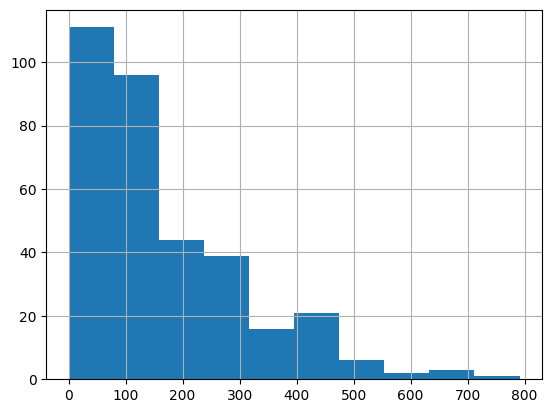

In [21]:
variance_surf_minutes_month = np.var(surf_minutes_month)

print('Los datos estadísticos del consumo de minutos de los usuarios del plan surf son:')
print('La media es de:',surf_minutes_month.mean())
print('La varianza es de:',variance_surf_minutes_month)
print('La desviación estándar es de:',np.sqrt(variance_surf_minutes_month))

surf_minutes_month.hist()


Los datos estadísticos del consumo de minutos de los usuarios del plan ultimate son:
La media es de: 160.416149068323
La varianza es de: 20097.202510084062
La desviación estándar es de: 141.76460245803273


<AxesSubplot:>

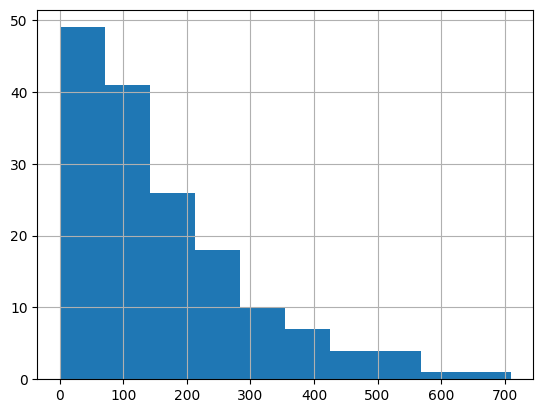

In [22]:
variance_ultimate_minutes_month = np.var(ultimate_minutes_month)

print('Los datos estadísticos del consumo de minutos de los usuarios del plan ultimate son:')
print('La media es de:',ultimate_minutes_month.mean())
print('La varianza es de:',variance_ultimate_minutes_month)
print('La desviación estándar es de:',np.sqrt(variance_ultimate_minutes_month))

ultimate_minutes_month.hist()

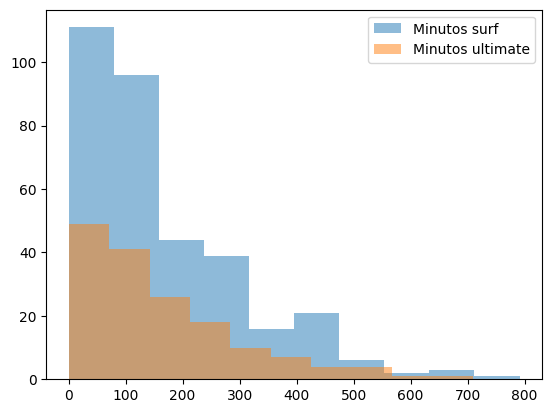

In [23]:
plt.hist(surf_minutes_month, alpha= 0.5, label='Minutos surf')
plt.hist(ultimate_minutes_month, alpha= 0.5, label='Minutos ultimate')
plt.legend(loc='upper right')
plt.show()


Conclusiones sobre el consumo de minutos de ambos planes:
- Ambos histogramas son muy similares entre sí, al igual que su media, su varianza y su desviación estándar.
- En en plan **surf** se incluyen 500 minutos al mes, la media de consumo es de 157 minutos.
- En el plan **ultimate** se incluyen 3,000 minutos al mes, la media de consumo es de 160 minutos. 
- En ambos planes, el consumo de minutos se encuentra por debajo de los minutos incluidos en cada paquete.  

##### Comparación del consumo de mensajes SMS mensuales según plan celular

Los datos estadísticos del consumo de mensajes de los usuarios del plan surf son:
La media es de: 12.048672566371682
La varianza es de: 230.84858148931298
La desviación estándar es de: 15.193702033714922


<AxesSubplot:>

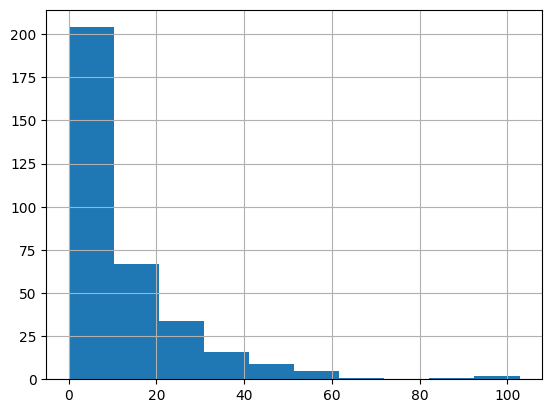

In [24]:
variance_surf_messages_month = np.var(surf_messages_month)

print('Los datos estadísticos del consumo de mensajes de los usuarios del plan surf son:')
print('La media es de:',surf_messages_month.mean())
print('La varianza es de:',variance_surf_messages_month)
print('La desviación estándar es de:',np.sqrt(variance_surf_messages_month))

surf_messages_month.hist()

Los datos estadísticos del consumo de mensajes de los usuarios del plan ultimate son:
La media es de: 13.994306418219463
La varianza es de: 271.99060767974487
La desviación estándar es de: 16.492137753479533


<AxesSubplot:>

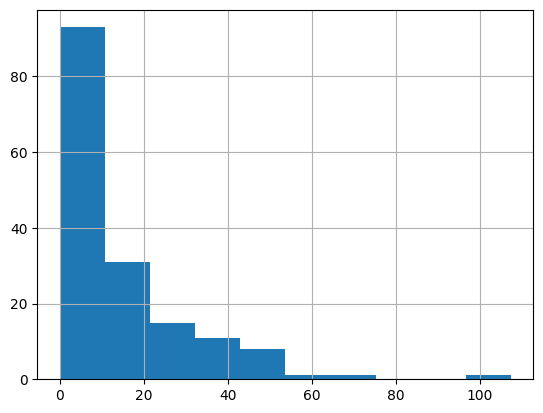

In [25]:
variance_ultimate_messages_month = np.var(ultimate_messages_month)

print('Los datos estadísticos del consumo de mensajes de los usuarios del plan ultimate son:')
print('La media es de:',ultimate_messages_month.mean())
print('La varianza es de:',variance_ultimate_messages_month)
print('La desviación estándar es de:',np.sqrt(variance_ultimate_messages_month))

ultimate_messages_month.hist()

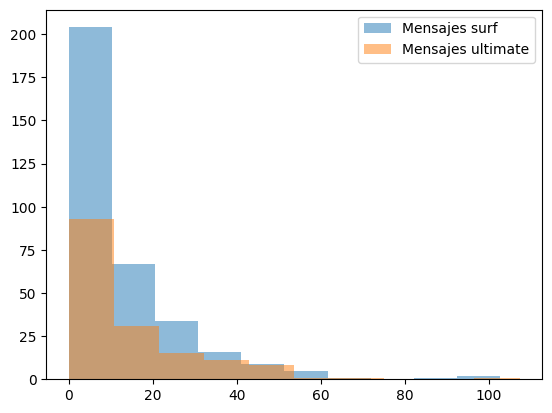

In [26]:
plt.hist(surf_messages_month, alpha= 0.5, label='Mensajes surf')
plt.hist(ultimate_messages_month, alpha= 0.5, label='Mensajes ultimate')
plt.legend(loc='upper right')
plt.show()

Conclusiones sobre el consumo de mensajes de ambos planes:
- Ambos histogramas son muy similares entre sí, al igual que su media, su varianza y su desviación estándar.
- En en plan **surf** se incluyen 50 mensajes al mes, la media de consumo es de 12 mensajes.
- En el plan **ultimate** se incluyen 1,000 mensajes al mes, la media de consumo es de 13 mensajes. 
- En ambos planes, el consumo de mensajes se encuentra por debajo de los mensajes incluidos en cada paquete.  

##### Comparación del consumo de megabytes mensuales según plan celular

Los datos estadísticos del consumo de gigabytes de los usuarios del plan surf son:
La media es de: 6.722713864306785
La varianza es de: 23.911312988922823
La desviación estándar es de: 4.889919527857573


<AxesSubplot:>

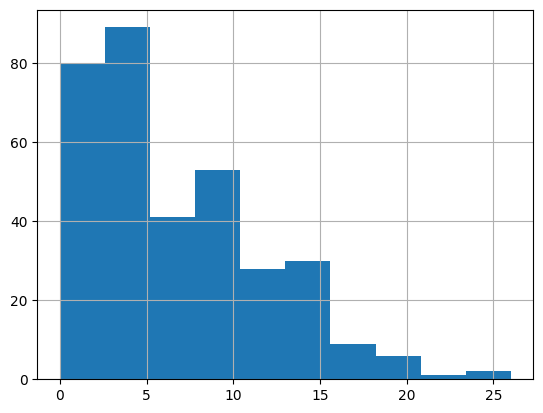

In [27]:
variance_surf_gigabytes_month = np.var(surf_gigabytes_month)

print('Los datos estadísticos del consumo de gigabytes de los usuarios del plan surf son:')
print('La media es de:',surf_gigabytes_month.mean())
print('La varianza es de:',variance_surf_gigabytes_month)
print('La desviación estándar es de:',np.sqrt(variance_surf_gigabytes_month))

surf_gigabytes_month.hist()

In [28]:
ultimate_gigabytes_month.describe()

count    161.000000
mean       6.714286
std        5.453701
min        0.000000
25%        3.000000
50%        5.000000
75%        9.000000
max       32.000000
Name: mb_used_rounded_gb_month, dtype: float64

Los datos estadísticos del consumo de gigabytes de los usuarios del plan ultimate son:
La media es de: 6.714285714285714
La varianza es de: 29.55811889973381
La desviación estándar es de: 5.436737891395336


<AxesSubplot:>

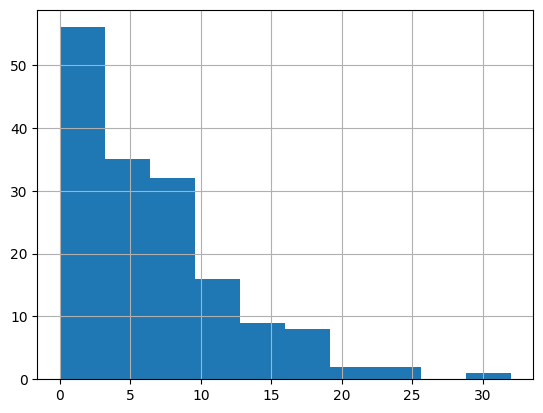

In [29]:
variance_ultimate_gigabytes_month = np.var(ultimate_gigabytes_month)

print('Los datos estadísticos del consumo de gigabytes de los usuarios del plan ultimate son:')
print('La media es de:',ultimate_gigabytes_month.mean())
print('La varianza es de:',variance_ultimate_gigabytes_month)
print('La desviación estándar es de:',np.sqrt(variance_ultimate_gigabytes_month))

ultimate_gigabytes_month.hist()

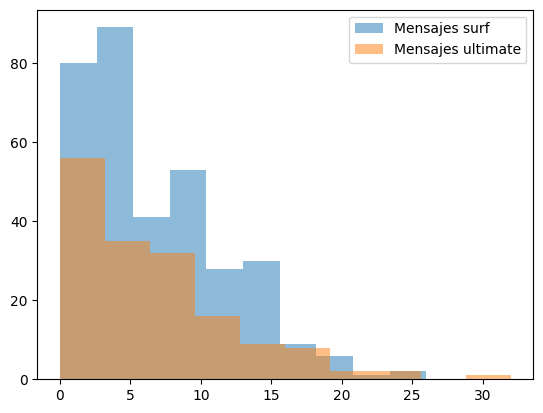

In [30]:
plt.hist(surf_gigabytes_month, alpha= 0.5, label='Mensajes surf')
plt.hist(ultimate_gigabytes_month, alpha= 0.5, label='Mensajes ultimate')
plt.legend(loc='upper right')
plt.show()

### Conclusiones sobre el consumo de gigabytes en ambos planes:

- Se observó que los histogramas correspondientes al consumo de gigabytes en los planes Surf y Ultimate son muy similares entre sí.
- Tanto en el plan Surf como en el plan Ultimate, se incluyen 15 gigabytes y 30 gigabytes al mes respectivamente.
- La media de consumo de gigabytes en ambos planes es de 6.7 gigabytes.
- En ambos planes, se encontró que el consumo de gigabytes se mantiene por debajo de los gigabytes incluidos en cada paquete.

---

### **Prueba de hipótesis 1**

En la primera prueba de hipótesis se propone como hipótesis nula la siguiente "el ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere", la hipótesis alternativa es "El ingreso promedio de los usuarios de las tarifas Ultimate y Surf es similar".

In [31]:
surf_monthly_profit = surf_user_table['monthly_profit']
ultimate_monthly_profit = ultimate_user_table['monthly_profit']

alpha = 0.05

result_test = st.ttest_ind(surf_monthly_profit, ultimate_monthly_profit)
print('p-value:', result_test.pvalue)

if result_test.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No rechazamos la hipótesis nula')


p-value: 1.578484055148577e-215
Rechazamos la hipótesis nula


### **Conclusiones de la prueba de hipótesis 1**

En la primera prueba de hipótesis, se plantea la siguiente hipótesis nula: "El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere". La hipótesis alternativa es: "El ingreso promedio de los usuarios de las tarifas Ultimate y Surf es similar".

El resultado del análisis estadístico arrojó un p-value de 1.578484055148577e-215. Con base en este valor, se rechaza la hipótesis nula. Esto indica que existe evidencia estadísticamente significativa para concluir que el ingreso promedio de los usuarios de las tarifas Surf y Ultimate es similar.


---

### **Prueba de hipótesis 2**

En la segunda prueba de hipótesis se propone como hipótesis nula que "el ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones" por lo que la hipótesis alternativa es que "el ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es similar al de los usuarios de otras regiones".

In [32]:
# Se creará la tabla correspondiente a New York-Newark-Jersey City y la tabla con el resto de las áreas metropolitanas

ny_nj = complete_table_user.query('metropolitan_area == "New York-Newark-Jersey City"')
not_ny_nj = complete_table_user.query('metropolitan_area != "New York-Newark-Jersey City"')


ny_nj_profit = ny_nj['monthly_profit']
not_ny_nj_profit = not_ny_nj['monthly_profit']

alpha = 0.05

result_test = st.ttest_ind(ny_nj_profit, not_ny_nj_profit)
print('p-value:', result_test.pvalue)

if result_test.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No rechazamos la hipótesis nula')

p-value: 0.13750813653908409
No rechazamos la hipótesis nula


### **Prueba de hipótesis 2**

En la segunda prueba de hipótesis, se plantea la siguiente hipótesis nula: "El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones". La hipótesis alternativa es: "El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es similar al de los usuarios de otras regiones".

El resultado de la segunda prueba de hipótesis indica que no se rechaza la hipótesis nula. Esto significa que no se encontró evidencia estadísticamente significativa para concluir que el ingreso promedio del área metropolitana de New York-Newark-Jersey City difiere del ingreso promedio de otras regiones de Estados Unidos.


---


### **Conclusiones**

### Resultados del Proyecto

El objetivo general de este proyecto fue apoyar al departamento comercial de Megaline en determinar qué plan genera más ingresos, para ajustar el presupuesto de publicidad. Se establecieron tres objetivos específicos y se trabajó con cinco conjuntos de datos correspondientes a una muestra de 500 clientes de Megaline del año 2018. Estos conjuntos de datos contenían información sobre usuarios, llamadas, mensajes SMS, sesiones web y detalles de las tarifas de los paquetes Surf y Ultimate.

#### Objetivos y Resultados

1. Descripción del comportamiento de los clientes: Se utilizó medidas estadísticas para describir el consumo mensual de minutos, mensajes SMS y volumen de datos de los clientes de cada tarifa. Se calculó la media, la varianza y la desviación estándar para cada uno de estos aspectos. Se observó que los histogramas y las medidas estadísticas eran muy similares para ambos planes, Surf y Ultimate.

2. Prueba de hipótesis sobre la diferencia en el ingreso promedio: Se planteó la hipótesis de que el ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere. Después de realizar pruebas estadísticas, se concluyó que no hay suficiente evidencia para rechazar la hipótesis nula. Esto indica que no se encontró una diferencia significativa en el ingreso promedio entre los usuarios de ambas tarifas.

3. Prueba de hipótesis sobre el ingreso promedio en el área de New York-Newark-Jersey City: Se planteó la hipótesis de que el ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones. Después de realizar pruebas estadísticas, se concluyó que no hay suficiente evidencia para rechazar la hipótesis nula. Esto indica que no se encontró una diferencia significativa en el ingreso promedio entre los usuarios del área mencionada y los usuarios de otras regiones.

#### Conclusiones

En resumen, en este proyecto se analizó el comportamiento de los clientes de Megaline en relación al consumo de minutos, mensajes SMS y volumen de datos. Aunque se observaron similitudes en los histogramas y medidas estadísticas para ambos planes, no se encontraron diferencias significativas en el ingreso promedio entre los usuarios de las tarifas Ultimate y Surf. Tampoco se encontraron diferencias significativas en el ingreso promedio entre los usuarios del área de New York-Newark-Jersey City y los usuarios de otras regiones.

Estos resultados pueden ayudar al departamento comercial de Megaline a tomar decisiones informadas sobre la asignación de presupuesto de publicidad y a comprender mejor el comportamiento de sus clientes en relación a los planes de prepago ofrecidos.
